In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras import backend as K
# os.environ["CUDA_VISIBLE_DEVICES"] = '3'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, Lambda, Dropout
from keras.layers import LeakyReLU, Multiply, add, dot, SeparableConv2D, DepthwiseConv2D, Reshape, Add, ReLU, Permute, Layer, InputSpec
from keras.regularizers import l2
from keras.models import Model, load_model, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras import regularizers
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
from PIL import Image
from tqdm import tqdm, trange
import random


Using TensorFlow backend.


In [2]:
nb_classes = 2  # number of classes
img_width, img_height = 64, 64  # change based on the shape/structure of your images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 300  # number of iteration the algorithm gets trained.

# Dir

In [3]:
train_dir = '/home/www/fake_detection/task2/128x128/train'
validation_dir = '/home/www/fake_detection/task2/128x128/validation'
test50_dir = '/home/www/fake_detection/task2/128x128/test_50'

# Xception

In [4]:
img_input = Input(shape=(img_height, img_width, 3))

# layer 1 #
x = Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='valid', use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# layer 2 #
x = Conv2D(filters=64, kernel_size=(3, 3), padding='valid', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# skip layer 1 #
res = Conv2D(filters=128, kernel_size=(1, 1), strides=2, padding='same', use_bias=False)(x)
res = BatchNormalization()(res)

# layer 3 #
x = SeparableConv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)

# layer 4 #
x = Activation('relu')(x)
x = SeparableConv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = Add()([x, res])

# skip layer 2 #
res = Conv2D(filters=256, kernel_size=(1, 1), strides=2, padding='same', use_bias=False)(x)
res = BatchNormalization()(res)

# layer 5 #
x = Activation('relu')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)

# layer 6 #
x = Activation('relu')(x)
x = SeparableConv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = Add()([x, res])

# skip layer 3 #
res = Conv2D(filters=728, kernel_size=(1, 1), strides=2, padding='same', use_bias=False)(x)
res = BatchNormalization()(res)

# layer 7 #
x = Activation('relu')(x)
x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)

# layer 8 #
x = Activation('relu')(x)
x = SeparableConv2D(filters=728, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = Add()([x, res])

# ======== middle flow ========= #
for i in range(8):
    # layer 9, 10, 11, 12, 13, 14, 15, 16, 17 #
    res = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)    

    x = Activation('relu')(x)
    x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = Add()([x, res])    

# ======== exit flow ========== #
# skip layer 4 #
res = Conv2D(filters=1024, kernel_size=(1, 1), strides=2, padding='same', use_bias=False)(x)
res = BatchNormalization()(res)

# layer 18 #
x = Activation('relu')(x)
x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)

# layer 19 #
x = Activation('relu')(x)
x = SeparableConv2D(filters=1024, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = Add()([x, res])

# layer 20 #
x = SeparableConv2D(filters=1536, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# layer 21 #
x = SeparableConv2D(filters=2048, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x_gap = GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='softmax')(x_gap)

model = Model(img_input, output)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 31, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 31, 31, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 31, 31, 32)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [5]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(len(model.trainable_weights))

150


# Data generator

In [6]:
train_datagen = ImageDataGenerator(rotation_range=20.0, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   rescale=1./255, )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 128404 images belonging to 2 classes.
Found 32100 images belonging to 2 classes.
Found 37566 images belonging to 2 classes.


In [7]:
model = load_model('/home/www/fake_detection/model/xception_94_96.h5')

In [8]:
def cutout(img):
    """
    # Function: RandomCrop (ZeroPadded (4, 4)) + random occulusion image
    # Arguments:
        img: image
    # Returns:
        img
    """
    height = img.shape[0]
    width = img.shape[1]
    channels = img.shape[2]
    MAX_CUTS = 3 # chance to get more cuts
    MAX_LENGTH_MUTIPLIER = 10 # chance to get larger cuts
    # 16 for cifar10, 8 for cifar100
    
    # Zero-padded (4, 4)
#     img = np.pad(img, ((4,4),(4,4),(0,0)), mode='constant', constant_values=(0))
    
#     # random-crop 64x64
#     dy, dx = height, width
#     x = np.random.randint(0, width - dx + 1)
#     y = np.random.randint(0, height - dy + 1)
#     img = img[y:(y+dy), x:(x+dx)]
    
#     mean norm
#     mean = img.mean(keepdims=True)
#     img -= mean

    img *= 1./255
    
    mask = np.ones((height, width, channels), dtype=np.float32)
    nb_cuts = np.random.randint(0, MAX_CUTS + 1)
    
    # cutout
    for i in range(nb_cuts):
        y = np.random.randint(height)
        x = np.random.randint(width)
        length = 4 * np.random.randint(1, MAX_LENGTH_MUTIPLIER+1)
        
        y1 = np.clip(y-length//2, 0, height)
        y2 = np.clip(y+length//2, 0, height)
        x1 = np.clip(x-length//2, 0, width)
        x2 = np.clip(x+length//2, 0, width)
        
        mask[y1:y2, x1:x2, :] = 0.
    
    img = img * mask
    return img

In [9]:
class ReLU6(Layer):
    def __init__(self):
        super().__init__(name="ReLU6")
        self.relu6 = ReLU(max_value=6, name="ReLU6")

    def call(self, input):
        return self.relu6(input)


class HardSigmoid(Layer):
    def __init__(self):
        super().__init__()
        self.relu6 = ReLU6()

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0


class HardSwish(Layer):
    def __init__(self):
        super().__init__()
        self.hard_sigmoid = HardSigmoid()

    def call(self, input):
        return input * self.hard_sigmoid(input)
    
class Attention(Layer):
    def __init__(self, ch, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        print(kernel_shape_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f')
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g')
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h')
        self.bias_f = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_F')
        self.bias_g = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_g')
        self.bias_h = self.add_weight(shape=(self.filters_h,),
                                      initializer='zeros',
                                      name='bias_h')
        super(Attention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True


    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[-1]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        f = K.bias_add(f, self.bias_f)
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.bias_add(g, self.bias_g)
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  # [bs, h, w, c]
        h = K.bias_add(h, self.bias_h)

        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map

        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape

In [10]:
ft_dir = '/home/www/fake_detection/task2/128x128/fine_tune'
train_gen_aug = ImageDataGenerator(shear_range=0, 
                               zoom_range=0.2,
                               rotation_range=0.2,
                               width_shift_range=2., 
                               height_shift_range=2.,
                               horizontal_flip=True,
                               zca_whitening=False,
                               fill_mode='nearest',
                               rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
ft_gen = train_gen_aug.flow_from_directory(ft_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 32100 images belonging to 2 classes.
Found 37566 images belonging to 2 classes.


In [11]:
model_ft = load_model('/home/www/fake_detection/model/xception_94_96.h5')
for i in range(2):
    model_ft.layers.pop()
im_in = Input(shape=(img_width, img_height, 3))

base_model = Model(img_input, x)
base_model.set_weights(model_ft.get_weights())
for i in range(len(base_model.layers) - 0):
    base_model.layers[i].trainable = False
    
x1 = base_model(im_in) # (12, 12, 32)
########### Mobilenet block bneck 3x3 (32 --> 128) #################
expand1 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(x1)
expand1 = BatchNormalization()(expand1)
expand1 = HardSwish()(expand1)
dw1 = DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand1)
dw1 = BatchNormalization()(dw1)
se_gap1 = GlobalAveragePooling2D()(dw1)
se_gap1 = Reshape([1, 1, -1])(se_gap1)
se1 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap1)
se1 = Activation('relu')(se1)
se1 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se1)
se1 = HardSigmoid()(se1)
se1 = Multiply()([expand1, se1])
project1 = HardSwish()(se1)
project1 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project1)
project1 = BatchNormalization()(project1)

# ########### Mobilenet block bneck 5x5 (128 --> 128) #################
# expand2 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project1)
# expand2 = BatchNormalization()(expand2)
# expand2 = HardSwish()(expand2)
# dw2 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand2)
# dw2 = BatchNormalization()(dw2)
# se_gap2 = GlobalAveragePooling2D()(dw2)
# se_gap2 = Reshape([1, 1, -1])(se_gap2)
# se2 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap2)
# se2 = Activation('relu')(se2)
# se2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se2)
# se2 = HardSigmoid()(se2)
# se2 = Multiply()([expand2, se2])
# project2 = HardSwish()(se2)
# project2 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project2)
# project2 = BatchNormalization()(project2)
# project2 = Add()([project1, project2])

# ########### Mobilenet block bneck 5x5 (128 --> 128) #################
# expand3 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project2)
# expand3 = BatchNormalization()(expand3)
# expand3 = HardSwish()(expand3)
# dw3 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand3)
# dw3 = BatchNormalization()(dw3)
# se_gap3 = GlobalAveragePooling2D()(dw3)
# se_gap3 = Reshape([1, 1, -1])(se_gap3)
# se3 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap3)
# se3 = Activation('relu')(se3)
# se3 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se3)
# se3 = HardSigmoid()(se3)
# se3 = Multiply()([expand3, se3])
# project3 = HardSwish()(se3)
# project3 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project3)
# project3 = BatchNormalization()(project3)
# project3 = Add()([project2, project3])

# expand4 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project3)
# expand4 = BatchNormalization()(expand4)
# expand4 = HardSwish()(expand4)
# dw4 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand4)
# dw4 = BatchNormalization()(dw4)
# se_gap4 = GlobalAveragePooling2D()(dw4)
# se_gap4 = Reshape([1, 1, -1])(se_gap4)
# se4 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap4)
# se4 = Activation('relu')(se4)
# se4 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se4)
# se4 = HardSigmoid()(se4)
# se4 = Multiply()([expand4, se4])
# project4 = HardSwish()(se4)
# project4 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project4)
# project4 = BatchNormalization()(project4)
# project4 = Add()([project3, project4])

########## Classification ##########
x2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project1)
x2 = BatchNormalization()(x2)
x2 = HardSwish()(x2)
x2 = GlobalAveragePooling2D()(x2)

# ######### Image Attention Model #########
# ### Block 1 ###
# x3 = SeparableConv2D(32, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(im_in)
# x3 = BatchNormalization()(x3)
# x3 = Activation('relu')(x3)
# x3 = Attention(32)(x3)

# ### Block 2 ###
# x4 = SeparableConv2D(64, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x3)
# x4 = BatchNormalization()(x4)
# x4 = Activation('relu')(x4)
# x4 = Attention(64)(x4)

# ### Block 3 ###
# x5 = SeparableConv2D(128, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x4)
# x5 = BatchNormalization()(x5)
# x5 = Activation('relu')(x5)
# x5 = Attention(128)(x5)

# ### final stage ###
# x6 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(x5)
# x6 = BatchNormalization()(x6)
# x6 = Activation('relu')(x6)
# x6 = GlobalAveragePooling2D()(x6)

# ######## final addition #########
# x2 = Add()([x2, x6])
x2 = Dense(2)(x2)
x2 = Activation('softmax')(x2)

model_top = Model(inputs=im_in, outputs=x2)
model_top.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 2, 2, 2048)   20857032    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 2, 2, 576)    1179648     model_2[1][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 2, 2, 576)    2304        conv2d_7[0][0]                   
____________________________________________________________________________________________

In [12]:
# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=True)
optimizer = Adam()
model_top.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
callback_list = [EarlyStopping(monitor='val_acc', patience=30), 
                 ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.5), cooldown=0, patience=5, min_lr=0.5e-5)]
output1 = model_top.fit_generator(ft_gen, steps_per_epoch=200, epochs=300,
                                  validation_data=validation_generator, validation_steps=len(validation_generator), callbacks=callback_list)

Epoch 1/300
200/200 [==============================] - 47s 237ms/step - loss: 0.4548 - acc: 0.8169 - val_loss: 0.1463 - val_acc: 0.8446
Epoch 2/300
200/200 [==============================] - 38s 192ms/step - loss: 0.4404 - acc: 0.8256 - val_loss: 0.1102 - val_acc: 0.8324
Epoch 3/300
200/200 [==============================] - 38s 192ms/step - loss: 0.4115 - acc: 0.8356 - val_loss: 0.1271 - val_acc: 0.8981
Epoch 4/300
200/200 [==============================] - 38s 191ms/step - loss: 0.4220 - acc: 0.8295 - val_loss: 0.4601 - val_acc: 0.8897
Epoch 5/300
200/200 [==============================] - 38s 190ms/step - loss: 0.4093 - acc: 0.8356 - val_loss: 0.2773 - val_acc: 0.9303
Epoch 6/300
200/200 [==============================] - 38s 191ms/step - loss: 0.3864 - acc: 0.8484 - val_loss: 0.4090 - val_acc: 0.8979
Epoch 7/300
200/200 [==============================] - 38s 190ms/step - loss: 0.3887 - acc: 0.8461 - val_loss: 0.2637 - val_acc: 0.9162
Epoch 8/300
200/200 [===========================

In [13]:
ft_dir = '/home/www/fake_detection/task2/128x128/fine_tune'
train_gen_aug = ImageDataGenerator(shear_range=0, 
                               zoom_range=0.2,
                               rotation_range=0.2,
                               width_shift_range=2., 
                               height_shift_range=2.,
                               horizontal_flip=True,
                               zca_whitening=False,
                               fill_mode='nearest',
                               preprocessing_function=cutout)
test_datagen = ImageDataGenerator(rescale=1./255)
ft_gen = train_gen_aug.flow_from_directory(ft_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 32100 images belonging to 2 classes.
Found 37566 images belonging to 2 classes.


In [14]:
model_ft = load_model('/home/www/fake_detection/model/xception_94_96.h5')
for i in range(2):
    model_ft.layers.pop()
im_in = Input(shape=(img_width, img_height, 3))

base_model = Model(img_input, x)
base_model.set_weights(model_ft.get_weights())
# for i in range(len(base_model.layers) - 0):
#     base_model.layers[i].trainable = False
    
x1 = base_model(im_in) # (12, 12, 32)
########### Mobilenet block bneck 3x3 (32 --> 128) #################
expand1 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(x1)
expand1 = BatchNormalization()(expand1)
expand1 = HardSwish()(expand1)
dw1 = DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand1)
dw1 = BatchNormalization()(dw1)
se_gap1 = GlobalAveragePooling2D()(dw1)
se_gap1 = Reshape([1, 1, -1])(se_gap1)
se1 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap1)
se1 = Activation('relu')(se1)
se1 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se1)
se1 = HardSigmoid()(se1)
se1 = Multiply()([expand1, se1])
project1 = HardSwish()(se1)
project1 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project1)
project1 = BatchNormalization()(project1)

########### Mobilenet block bneck 5x5 (128 --> 128) #################
expand2 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project1)
expand2 = BatchNormalization()(expand2)
expand2 = HardSwish()(expand2)
dw2 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand2)
dw2 = BatchNormalization()(dw2)
se_gap2 = GlobalAveragePooling2D()(dw2)
se_gap2 = Reshape([1, 1, -1])(se_gap2)
se2 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap2)
se2 = Activation('relu')(se2)
se2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se2)
se2 = HardSigmoid()(se2)
se2 = Multiply()([expand2, se2])
project2 = HardSwish()(se2)
project2 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project2)
project2 = BatchNormalization()(project2)
project2 = Add()([project1, project2])

########### Mobilenet block bneck 5x5 (128 --> 128) #################
expand3 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project2)
expand3 = BatchNormalization()(expand3)
expand3 = HardSwish()(expand3)
dw3 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand3)
dw3 = BatchNormalization()(dw3)
se_gap3 = GlobalAveragePooling2D()(dw3)
se_gap3 = Reshape([1, 1, -1])(se_gap3)
se3 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap3)
se3 = Activation('relu')(se3)
se3 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se3)
se3 = HardSigmoid()(se3)
se3 = Multiply()([expand3, se3])
project3 = HardSwish()(se3)
project3 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project3)
project3 = BatchNormalization()(project3)
project3 = Add()([project2, project3])

expand4 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project3)
expand4 = BatchNormalization()(expand4)
expand4 = HardSwish()(expand4)
dw4 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand4)
dw4 = BatchNormalization()(dw4)
se_gap4 = GlobalAveragePooling2D()(dw4)
se_gap4 = Reshape([1, 1, -1])(se_gap4)
se4 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap4)
se4 = Activation('relu')(se4)
se4 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se4)
se4 = HardSigmoid()(se4)
se4 = Multiply()([expand4, se4])
project4 = HardSwish()(se4)
project4 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project4)
project4 = BatchNormalization()(project4)
project4 = Add()([project3, project4])

########## Classification ##########
x2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project4)
x2 = BatchNormalization()(x2)
x2 = HardSwish()(x2)
x2 = GlobalAveragePooling2D()(x2)

######### Image Attention Model #########
### Block 1 ###
x3 = SeparableConv2D(32, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(im_in)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Attention(32)(x3)

### Block 2 ###
x4 = SeparableConv2D(64, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x3)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Attention(64)(x4)

### Block 3 ###
x5 = SeparableConv2D(128, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x4)
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = Attention(128)(x5)

### final stage ###
x6 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = GlobalAveragePooling2D()(x6)

######## final addition #########
x2 = Add()([x2, x6])
x2 = Dense(2)(x2)
x2 = Activation('softmax')(x2)

model_top = Model(inputs=im_in, outputs=x2)
model_top.summary()

(1, 1, 32, 4)
(1, 1, 64, 8)
(1, 1, 128, 16)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 2, 2, 2048)   20857032    input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 2, 2, 576)    1179648     model_4[1][0]                    
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 2, 2, 576)    2304        conv2d_25[0][0]                  
________________________________________________

Non-trainable params: 20,870,024
__________________________________________________________________________________________________


In [15]:
# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=True)
optimizer = Adam()
model_top.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
callback_list = [EarlyStopping(monitor='val_acc', patience=30), 
                 ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.5), cooldown=0, patience=5, min_lr=0.5e-5)]
output2 = model_top.fit_generator(ft_gen, steps_per_epoch=200, epochs=300,
                                  validation_data=validation_generator, validation_steps=len(validation_generator), callbacks=callback_list)

Epoch 1/300
200/200 [==============================] - 47s 237ms/step - loss: 0.5450 - acc: 0.7631 - val_loss: 0.2477 - val_acc: 0.8478
Epoch 2/300
200/200 [==============================] - 41s 204ms/step - loss: 0.5143 - acc: 0.7793 - val_loss: 0.1552 - val_acc: 0.8690
Epoch 3/300
200/200 [==============================] - 42s 208ms/step - loss: 0.4916 - acc: 0.7851 - val_loss: 0.1346 - val_acc: 0.9040
Epoch 4/300
200/200 [==============================] - 39s 197ms/step - loss: 0.5019 - acc: 0.7800 - val_loss: 0.0919 - val_acc: 0.8555
Epoch 5/300
200/200 [==============================] - 39s 195ms/step - loss: 0.4947 - acc: 0.7807 - val_loss: 0.3724 - val_acc: 0.9170
Epoch 6/300
200/200 [==============================] - 40s 199ms/step - loss: 0.4737 - acc: 0.7994 - val_loss: 0.1833 - val_acc: 0.9280
Epoch 7/300
200/200 [==============================] - 39s 193ms/step - loss: 0.4706 - acc: 0.8002 - val_loss: 0.0921 - val_acc: 0.8892
Epoch 8/300
200/200 [===========================

In [16]:
output_score50 = []
output_class50 = []
answer_class50 = []
answer_class50_1 =[]

for i in trange(len(test50_generator)):
    output50 = model_top.predict_on_batch(test50_generator[i][0])
    output_score50.append(output50)
    answer_class50.append(test50_generator[i][1])
    
output_score50 = np.concatenate(output_score50)
answer_class50 = np.concatenate(answer_class50)

output_class50 = np.argmax(output_score50, axis=1)
answer_class50_1 = np.argmax(answer_class50, axis=1)

print(output_class50)
print(answer_class50_1)

100%|██████████| 1174/1174 [01:17<00:00, 15.07it/s]

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [17]:
cm50 = confusion_matrix(answer_class50_1, output_class50)
report50 = classification_report(answer_class50_1, output_class50)

recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
thresh50 = interp1d(fpr50, thresholds50)(eer50)

print(report50)
print(cm50)
print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
print(thresh50)
print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87     18788
           1       0.84      0.91      0.88     18778

    accuracy                           0.87     37566
   macro avg       0.88      0.87      0.87     37566
weighted avg       0.88      0.87      0.87     37566

[[15597  3191]
 [ 1602 17176]]
AUROC: 0.939835
0.6264597090211346
test_acc:  0.8724112229143375


<Figure size 216x288 with 0 Axes>

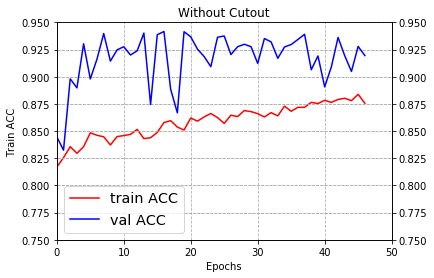

In [53]:
plt.figure(figsize = (3, 4))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Train ACC")
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)
ax1.set_ylim(0.75, 0.95)
ax2.set_ylim(0.75, 0.95)
lines = line1 + line2
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, fontsize='x-large')
plt.title('Without Cutout')
plt.grid(which='major', axis='both', linestyle='--')
ax1.grid(which='major', axis='both', linestyle='--')

In [54]:
fig.savefig("fig3.png")

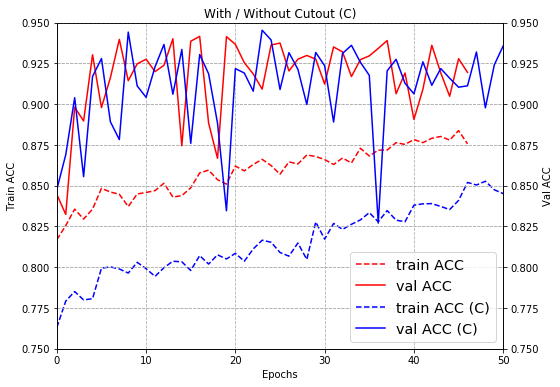

In [79]:
plt.rcParams["figure.figsize"] = (8,6)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
line1 = ax1.plot(output1.history['acc'], 'r--', label='train ACC')
line2 = ax2.plot(output1.history['val_acc'], 'r', label='val ACC')
line3 = ax1.plot(output2.history['acc'], 'b--', label='train ACC (C)')
line4 = ax2.plot(output2.history['val_acc'], 'b', label='val ACC (C)')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Train ACC")
ax2.set_ylabel("Val ACC")
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)
ax1.set_ylim(0.75, 0.95)
ax2.set_ylim(0.75, 0.95)
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, fontsize='x-large', loc=4)
plt.title('With / Without Cutout (C)')
plt.grid(which='major', axis='both', linestyle='--')
ax1.grid(which='major', axis='both', linestyle='--')

In [80]:
fig.savefig("fig_ab2.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [85]:
import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [81]:
def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [82]:
train_dir = '/mnt/a/fakedata/deepfake/train'
validation_dir = '/mnt/a/fakedata/deepfake/val'
test50_dir = '/mnt/a/fakedata/deepfake/test'

In [83]:
ft_dir = '/mnt/a/fakedata/deepfake/finetune'
train_gen_aug = ImageDataGenerator(shear_range=0, 
                               zoom_range=0,
                               rotation_range=0.2,
                               width_shift_range=2., 
                               height_shift_range=2.,
                               horizontal_flip=True,
                               zca_whitening=False,
                               fill_mode='nearest',
                               preprocessing_function=cutout)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=bgr)

ft_gen = train_gen_aug.flow_from_directory(ft_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [86]:
output_score50 = []
output_class50 = []
answer_class50 = []
answer_class50_1 =[]

for i in trange(len(test50_generator)):
    output50 = model_top.predict_on_batch(test50_generator[i][0])
    output_score50.append(output50)
    answer_class50.append(test50_generator[i][1])
    
output_score50 = np.concatenate(output_score50)
answer_class50 = np.concatenate(answer_class50)

output_class50 = np.argmax(output_score50, axis=1)
answer_class50_1 = np.argmax(answer_class50, axis=1)

print(output_class50)
print(answer_class50_1)

100%|██████████| 625/625 [02:16<00:00,  4.57it/s]

[0 1 1 ... 0 0 0]
[0 0 0 ... 1 1 1]


In [87]:
cm50 = confusion_matrix(answer_class50_1, output_class50)
report50 = classification_report(answer_class50_1, output_class50)

recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
thresh50 = interp1d(fpr50, thresholds50)(eer50)

print(report50)
print(cm50)
print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
print(thresh50)
print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

              precision    recall  f1-score   support

           0       0.55      0.65      0.59     10000
           1       0.57      0.46      0.51     10000

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.55     20000
weighted avg       0.56      0.56      0.55     20000

[[6519 3481]
 [5412 4588]]
AUROC: 0.580201
0.3503145178159078
test_acc:  0.55535


In [88]:
# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=True)
optimizer = Adam()
model_top.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
callback_list = [EarlyStopping(monitor='val_acc', patience=30), 
                 ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.5), cooldown=0, patience=5, min_lr=0.5e-5)]
output2 = model_top.fit_generator(ft_gen, steps_per_epoch=200, epochs=300,
                                  validation_data=validation_generator, validation_steps=len(validation_generator), callbacks=callback_list)

Epoch 1/300
200/200 [==============================] - 86s 431ms/step - loss: 0.7813 - acc: 0.5102 - val_loss: 0.7497 - val_acc: 0.5276
Epoch 2/300
200/200 [==============================] - 79s 396ms/step - loss: 0.7083 - acc: 0.5443 - val_loss: 1.3197 - val_acc: 0.5026
Epoch 3/300
200/200 [==============================] - 80s 400ms/step - loss: 0.6910 - acc: 0.5683 - val_loss: 0.8944 - val_acc: 0.5107
Epoch 4/300
200/200 [==============================] - 79s 396ms/step - loss: 0.6901 - acc: 0.5756 - val_loss: 0.7428 - val_acc: 0.5233
Epoch 5/300
200/200 [==============================] - 81s 407ms/step - loss: 0.6685 - acc: 0.6001 - val_loss: 0.6229 - val_acc: 0.5159
Epoch 6/300
200/200 [==============================] - 81s 407ms/step - loss: 0.6616 - acc: 0.6171 - val_loss: 0.9108 - val_acc: 0.5148
Epoch 7/300
200/200 [==============================] - 82s 412ms/step - loss: 0.6506 - acc: 0.6278 - val_loss: 0.4834 - val_acc: 0.5130
Epoch 8/300
200/200 [===========================

In [89]:
output_score50 = []
output_class50 = []
answer_class50 = []
answer_class50_1 =[]

for i in trange(len(test50_generator)):
    output50 = model_top.predict_on_batch(test50_generator[i][0])
    output_score50.append(output50)
    answer_class50.append(test50_generator[i][1])
    
output_score50 = np.concatenate(output_score50)
answer_class50 = np.concatenate(answer_class50)

output_class50 = np.argmax(output_score50, axis=1)
answer_class50_1 = np.argmax(answer_class50, axis=1)

print(output_class50)
print(answer_class50_1)

100%|██████████| 625/625 [03:07<00:00,  3.34it/s]

[1 1 1 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [90]:
cm50 = confusion_matrix(answer_class50_1, output_class50)
report50 = classification_report(answer_class50_1, output_class50)

recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
thresh50 = interp1d(fpr50, thresholds50)(eer50)

print(report50)
print(cm50)
print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
print(thresh50)
print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

              precision    recall  f1-score   support

           0       0.53      0.14      0.22     10000
           1       0.50      0.87      0.64     10000

    accuracy                           0.51     20000
   macro avg       0.52      0.51      0.43     20000
weighted avg       0.52      0.51      0.43     20000

[[1423 8577]
 [1271 8729]]
AUROC: 0.524830
0.7097904086116652
test_acc:  0.5076


In [92]:
# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=True)
optimizer = Adam()
model_top.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
callback_list = [EarlyStopping(monitor='val_acc', patience=30), 
                 ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.5), cooldown=0, patience=5, min_lr=0.5e-5)]
output2 = model_top.fit_generator(ft_gen, steps_per_epoch=200, epochs=300,
                                  validation_data=validation_generator, validation_steps=len(validation_generator), callbacks=callback_list)
output_score50 = []
output_class50 = []
answer_class50 = []
answer_class50_1 =[]

for i in trange(len(test50_generator)):
    output50 = model_top.predict_on_batch(test50_generator[i][0])
    output_score50.append(output50)
    answer_class50.append(test50_generator[i][1])
    
output_score50 = np.concatenate(output_score50)
answer_class50 = np.concatenate(answer_class50)

output_class50 = np.argmax(output_score50, axis=1)
answer_class50_1 = np.argmax(answer_class50, axis=1)

print(output_class50)
print(answer_class50_1)
cm50 = confusion_matrix(answer_class50_1, output_class50)
report50 = classification_report(answer_class50_1, output_class50)

recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
thresh50 = interp1d(fpr50, thresholds50)(eer50)

print(report50)
print(cm50)
print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
print(thresh50)
print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

Epoch 1/300
200/200 [==============================] - 88s 439ms/step - loss: 0.7866 - acc: 0.5189 - val_loss: 0.4833 - val_acc: 0.5000
Epoch 2/300
200/200 [==============================] - 75s 375ms/step - loss: 0.7502 - acc: 0.5447 - val_loss: 0.5889 - val_acc: 0.5004
Epoch 3/300
200/200 [==============================] - 72s 362ms/step - loss: 0.7300 - acc: 0.5705 - val_loss: 0.5706 - val_acc: 0.5759
Epoch 4/300
200/200 [==============================] - 70s 351ms/step - loss: 0.7019 - acc: 0.6099 - val_loss: 0.3835 - val_acc: 0.5883
Epoch 5/300
200/200 [==============================] - 70s 350ms/step - loss: 0.6836 - acc: 0.6174 - val_loss: 0.7617 - val_acc: 0.5421
Epoch 6/300
200/200 [==============================] - 70s 350ms/step - loss: 0.6555 - acc: 0.6429 - val_loss: 1.4850 - val_acc: 0.4999
Epoch 7/300
200/200 [==============================] - 72s 362ms/step - loss: 0.6557 - acc: 0.6420 - val_loss: 0.7903 - val_acc: 0.5232
Epoch 8/300
200/200 [===========================

KeyboardInterrupt: 